# Objective
The problem will be project will have 2 parts - classification, predicting if a claim has occured, and regression, predicting the value of a claim assuming a claim has been made.

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier

from scipy.stats import randint, uniform

# Reading the data and inspection

In [34]:
raw_data = pd.read_csv('data/car_insurance_claim.csv')


In [35]:
pd.set_option('display.max_columns', None)


In [36]:
raw_data.head()

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,M,Bachelors,Manager,26,Private,"$21,970",1,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


# Basic Data Cleaning

In [37]:
# Create new copy of data
data_df = raw_data.copy()

First we will rename the columns to make them more description so they are easier to work with.

In [38]:
# Define updated column names
col_names = {
    'KIDSDRIV': 'num_young_drivers',
    'BIRTH': 'date_of_birth',
    'AGE': 'age',
    'HOMEKIDS': 'num_of_children',
    'YOJ': 'years_job_held_for',
    'INCOME': 'income',
    'PARENT1': 'single_parent',
    'HOME_VAL': 'value_of_home',
    'MSTATUS': 'married',
    'GENDER': 'gender',
    'EDUCATION': 'highest_education',
    'OCCUPATION': 'occupation',
    'TRAVTIME': 'commute_dist',
    'CAR_USE': 'type_of_use',
    'BLUEBOOK': 'vehicle_value',
    'TIF': 'policy_tenure',
    'CAR_TYPE': 'vehicle_type',
    'RED_CAR': 'red_vehicle',
    'OLDCLAIM': '5_year_total_claims_value',
    'CLM_FREQ': '5_year_num_of_claims',
    'REVOKED': 'licence_revoked',
    'MVR_PTS': 'license_points',
    'CLM_AMT': 'new_claim_value',
    'CAR_AGE': 'vehicle_age',
    'CLAIM_FLAG': 'is_claim',
    'URBANICITY': 'address_type'
}

# Update column names
data_df.rename(columns=col_names, inplace=True)

In [56]:
data_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 10301 entries, 0 to 10301
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   num_young_drivers          10301 non-null  int64   
 1   age                        10294 non-null  float64 
 2   num_of_children            10301 non-null  int64   
 3   years_job_held_for         9753 non-null   float64 
 4   income                     9731 non-null   Int64   
 5   single_parent              10301 non-null  object  
 6   value_of_home              9726 non-null   Int64   
 7   married                    10301 non-null  object  
 8   gender                     10301 non-null  object  
 9   highest_education          10301 non-null  object  
 10  occupation                 9636 non-null   object  
 11  commute_dist               10301 non-null  int64   
 12  type_of_use                10301 non-null  object  
 13  vehicle_value              10301 non

In [40]:
# Check number of duplicate records
data_df.duplicated().sum()

np.int64(1)

We have a single duplictae, so let's proceed with dropping it.

In [41]:
# Drop duplicates
data_df.drop_duplicates(inplace=True)

The currency based columns include values with '$' and ','. We need to remove these characters and convert the values to integers.

In [42]:
# Define currency based columns
currency_cols = ['income', 'value_of_home', 'vehicle_value', '5_year_total_claims_value', 'new_claim_value']

# Create function to remove '$' and ','
def format_currency_cols(data, cols):
    for col in cols:
        data[col] = data[col].replace('[\\$,]', '', regex=True).astype('Int64')
    return data

data_df = format_currency_cols(data_df, currency_cols)

Many records across multiple features include a 'z_' prefix. This must be removed.

In [43]:
# Define columns that have prefix
z_prefix_cols = ['married', 'gender', 'highest_education', 'occupation', 'vehicle_type', 'address_type']

# Create function to remove 'z_' prefix
def remove_prefix(data, cols):
    for col in cols:
        data[col] = data[col].replace('[z_]', '', regex=True)
    return data

data_df = remove_prefix(data_df, z_prefix_cols)

At this stage we can drop unuseful features:
* ID is just a unique identifier so is not needed
* data_of_birth duplicates the age feature (as age infers this information) so is not needed

In [44]:
data_df.drop(['ID', 'date_of_birth'], axis=1, inplace=True)


In [45]:
data_df.head()


,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,0,60.0,0,11.0,67349,No,0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,91449,No,257252,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,52881,No,0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,16039,No,124191,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


# Create Train/Test Split
Since no test set is provided by the authoer, we'll hold out a portion of the data as our test set.

In terms of creating our test set, our best option here would be to use stratified sampling to prevent bias. We can do this by creating bins (strata) based on the 'new_claim_value' amount, as non-zero values here imply 'is_claim' is 1 (true) anyway. We can double check this before doing out stratified sampling:

In [46]:
# Check there are no non-zero values for 'new_claim_value' where 'is_claim' = 1
mask = (data_df['new_claim_value'] > 0) & (data_df['is_claim'] == 0)
data_df[mask]

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type


Good, so we can see when 'new_claim_value' is greater than 0, 'is_claim' is always 1, which is what we would expect.

Let's now see the distribution for claim values to help define the number and width of bins we should use:

<Axes: xlabel='new_claim_value', ylabel='Count'>

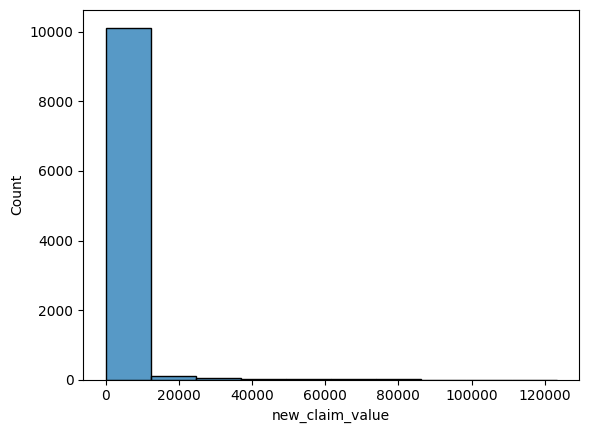

In [47]:
# Create hisogram for new claim value
sns.histplot(data_df['new_claim_value'], bins=10)

We can see the feature is heavily skewed right. It would likely be best to use non-linearly spaced bins to capture the more extreme values with few instances.

In [48]:
# Define bins
bins = [0.0, 5000, 10_000, 15_000, 20_000, 25_000, 30_000, 35_000, 40_000, 45_000, 50_000, np.inf]
# Define bin labels
labels = np.arange(1, 12)

# Apply the bins using cut
data_df['claim_value_cat'] = pd.cut(data_df['new_claim_value'], bins = bins, labels= labels, include_lowest=True)

We can now see the distribution of our new_claim_value categories by creating a barplot.



<Axes: ylabel='claim_value_cat'>

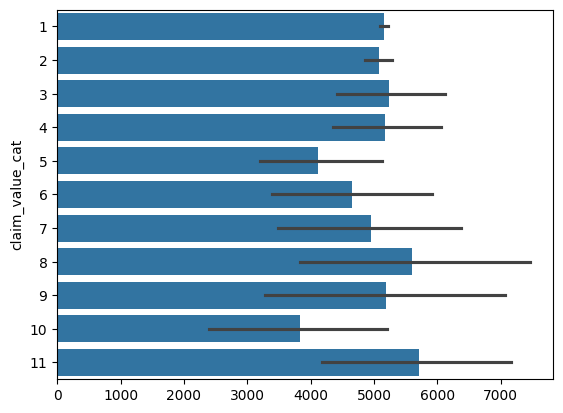

In [49]:
sns.barplot(data_df['claim_value_cat'])


The distribution looks ok for now, so we'll proceed with creating the split.

In [50]:
# Create clean copy of training data
X = data_df.copy()
y = data_df['is_claim']

# Drop the target feature
X.drop(columns=['new_claim_value','is_claim'], inplace=True)

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['claim_value_cat'])

We can quickly compare the distibution of positive/negative class for 'is_claim' in the y_train and y_test classes:


In [51]:
train_ratio = round((y_train.sum()/len(y_train))*100,2)
test_ratio = round((y_test.sum()/len(y_test)*100),2)

print(f'Train positive class ratio: {train_ratio}%')
print(f'Test positive class ratio: {test_ratio}%')

Train positive class ratio: 26.48%
Test positive class ratio: 27.37%


In [52]:
for set_ in (X_train, X_test):
    set_.drop(columns=['claim_value_cat'], inplace=True)

This looks good. We now need to drop the claim_value_cat feature from our X train and test sets:



## Exploratory Data Analysis (EDA)
# Preparation
For the purpose of our EDA, we'll join X_train and y_train so we can investigate correlation.



In [53]:
# Create a new copy of X_train for the analysis
eda_test_data = X_train.copy()
eda_test_data['is_claim'] = y_train


For the purpose of the exploration, we will first update 'Yes/No' features to bonary so we can see how these correlate too. We'll also update gender to use binary values. 1 = male, 0 = female

In [54]:
# Define binary columns
binary_cols = ['single_parent', 'married', 'gender', 'red_vehicle', 'licence_revoked']

# Define map values
mapping = {'Yes': 1,
           'No': 0,
           'yes': 1,
           'no': 0,
           'M': 1,
           'F': 0,
           }

# Define function to binarise features
def binarise_values(data, cols, map):
    for col in cols:
        data[col] = data[col].map(map)
    return data

# Call function
eda_test_data = binarise_values(eda_test_data, binary_cols, mapping)

In [55]:
# Check updated values
eda_test_data.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,address_type,is_claim
8452,0,57.0,0,NaN,33707,0,0,0,0,<High School,Blue Collar,40,Private,7200,10,SUV,0,0,0,0,1,1.0,Highly Rural/ Rural,0
7822,2,41.0,3,14.0,17321,0,109835,1,0,<High School,Blue Collar,24,Private,6530,4,Sports Car,0,0,0,0,3,1.0,Highly Urban/ Urban,0
1312,0,29.0,2,12.0,54310,1,174139,0,1,<High School,Clerical,39,Private,1500,4,Minivan,0,5419,1,0,5,6.0,Highly Urban/ Urban,1
921,0,46.0,1,13.0,62886,1,202178,0,0,Bachelors,Professional,18,Private,22260,1,Minivan,0,5290,1,0,6,6.0,Highly Urban/ Urban,0
8708,0,39.0,0,8.0,115182,0,312887,1,1,High School,Professional,25,Commercial,5400,1,Pickup,0,0,0,0,1,5.0,Highly Urban/ Urban,0


## Correlation Matrix
As there are many features, we'll create a correlation matrix from just the is_claim target feature.

In [57]:
eda_test_data.corr(numeric_only=True).sort_values(by='is_claim',ascending=False)


,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,commute_dist,vehicle_value,policy_tenure,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,is_claim
is_claim,0.109085,-0.107146,0.128697,-0.053815,-0.147085,0.154323,-0.193881,-0.132326,-0.021205,0.044019,-0.103979,-0.082839,-0.007045,0.147094,0.224952,0.158972,0.218605,-0.113344,1.000000
5_year_num_of_claims,0.034724,-0.037820,0.038404,-0.026019,-0.044323,0.060335,-0.092703,-0.070880,0.014060,0.006396,-0.034264,-0.015396,0.027464,0.491048,1.000000,0.054301,0.403083,-0.023960,0.224952
license_points,0.052874,-0.079780,0.071365,-0.040719,-0.065223,0.074748,-0.097057,-0.050486,-0.006218,0.006975,-0.053148,-0.032602,0.004845,0.267866,0.403083,0.054818,1.000000,-0.035502,0.218605
licence_revoked,0.040039,-0.045184,0.051109,-0.009085,-0.031050,0.052374,-0.048395,-0.039376,-0.024676,0.002763,-0.028597,-0.029388,-0.018617,0.422329,0.054301,1.000000,0.054818,-0.027414,0.158972
single_parent,0.204141,-0.314111,0.456293,-0.027043,-0.069598,1.000000,-0.248240,-0.476495,-0.061451,-0.016323,-0.042579,0.009828,-0.039510,0.044080,0.060335,0.052374,0.074748,-0.063892,0.154323
5_year_total_claims_value,0.035981,-0.040818,0.049397,-0.005708,-0.049042,0.044080,-0.067330,-0.043098,-0.009735,-0.017241,-0.030692,-0.012395,0.006578,1.000000,0.491048,0.422329,0.267866,-0.031716,0.147094
num_of_children,0.461488,-0.448207,1.000000,0.079570,-0.158150,0.456293,-0.106974,0.037708,-0.114426,-0.000621,-0.109210,0.012882,-0.072370,0.049397,0.038404,0.051109,0.071365,-0.152561,0.128697
num_young_drivers,1.000000,-0.076813,0.461488,0.038082,-0.046508,0.204141,-0.022470,0.037441,-0.041781,0.012918,-0.026245,-0.004106,-0.045062,0.035981,0.034724,0.040039,0.052874,-0.062621,0.109085
commute_dist,0.012918,0.003201,-0.000621,-0.008878,-0.051479,-0.016323,-0.031111,0.007881,-0.007181,1.000000,-0.024179,-0.002833,0.015903,-0.017241,0.006396,0.002763,0.006975,-0.037156,0.044019
red_vehicle,-0.045062,0.028833,-0.072370,0.054180,0.061301,-0.039510,0.027262,-0.018030,0.664545,0.015903,0.028362,-0.010116,1.000000,0.006578,0.027464,-0.018617,0.004845,0.012896,-0.007045


Use Seaborn to create a single column heatmap plot, sorted by correlation value.

<Axes: >

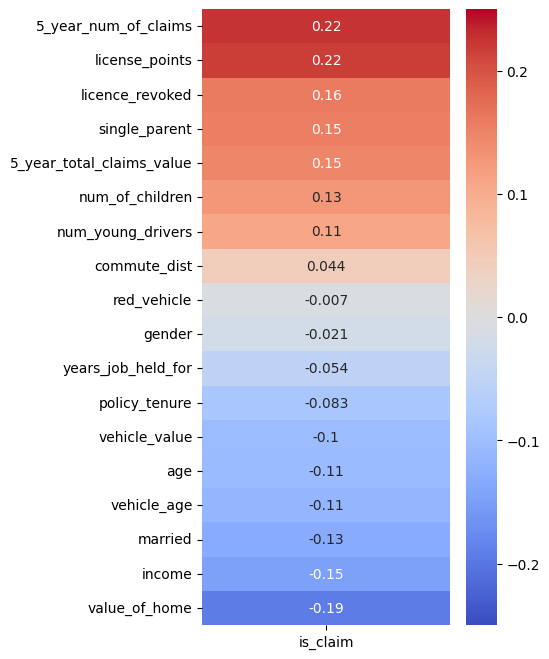

In [59]:
fig, ax = plt.subplots(figsize=(4, 8))

corr_matrix = eda_test_data.corr(numeric_only=True).sort_values(by='is_claim',ascending=False)
corr_matrix_no_claim = corr_matrix.drop('is_claim')

sns.heatmap(corr_matrix_no_claim[['is_claim']],cmap='coolwarm', annot=True, vmax=0.25, vmin=-0.25)

## Obervations:

Note, we are not assuming causation, only speculating at possible reasons for correlation.

Some of the features show much stronger positive correlation than others - these are perhaps the most expected, including:

* 5_year_num_of_claims: Having made claims previously would suggest they are more likely to make claims in the future
* license_points: Having points on your license may suggest your driving quality is poor, and make you more likely to be involved in an accident 
* license_revoked: Having your license revoked suggests several minor or a serious driving related offense, perhaps reflecting your driving quality
* Stronger negative correlations:

a.  Home value
* Features with negligable correlation:
b. Commute distance, red vehicle and gender show very weak correlations, so it may be beneficial to remove these to reduce the number of features passed to the models

## Data Cleaning and Preprocessing
# Dropping Features
We'll start by dropping the 'red_vehicle' feature, as this showed next to no correlation with the target variable.

In [60]:
X_train_raw = X_train.copy()

cols_to_drop = [
    'red_vehicle',
]

X_train_raw.drop(columns=cols_to_drop, axis=1, inplace=True)

## Handling Missing Values
Let's inspect how many missing values there are in the test data:

In [61]:
# Check the number of missing values in each row
X_train_raw.isnull().sum().sum()

np.int64(2418)

In [62]:
# Check how many missing values there are in each feature
X_train_raw.isnull().sum()

num_young_drivers              0
age                            5
num_of_children                0
years_job_held_for           433
income                       474
single_parent                  0
value_of_home                462
married                        0
gender                         0
highest_education              0
occupation                   527
commute_dist                   0
type_of_use                    0
vehicle_value                  0
policy_tenure                  0
vehicle_type                   0
5_year_total_claims_value      0
5_year_num_of_claims           0
licence_revoked                0
license_points                 0
vehicle_age                  517
address_type                   0
dtype: int64

There is a fairly significant number of missing values. We will need to deal with these when developing the data pipeline. As there are quite a lot of missing values, and many of which are numerical, simple imputation like median or mean may be too naive. Instead, let's impute using KNN for more advanced imputation.

In [63]:
# Create the imputer
knn_imputer = KNNImputer(n_neighbors=2)

# Define the numerical columns
numerical_cols_df = X_train_raw.select_dtypes(include=['number'])
numerical_cols = numerical_cols_df.columns.tolist()

# Define the categorial columns for use later
cat_cols_df = X_train_raw.select_dtypes(include=['object'])
cat_cols = cat_cols_df.columns.tolist()

In [64]:
# Define function to impute num features using KNN
def num_knn_impute(data, cols, imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data))
    data_imputed.columns = data.columns
    return data_imputed

# Run the function to impute numerical values with knn
num_test_data_imputed = num_knn_impute(X_train_raw, numerical_cols, knn_imputer)

We can now check some of the records that had missing data, and the subsequent imputations:



In [65]:
# Get numerical cols as a df
num_cols_df = X_train_raw[numerical_cols].reset_index(drop=True)
# Select rows with missing values and show head
missing_data_df = num_cols_df[num_cols_df.isna().any(axis=1)]
missing_data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age
0,0,57.0,0,NaN,33707,0,40,7200,10,0,0,1,1.0
11,0,36.0,2,13.0,19934,<NA>,17,10790,6,7797,2,9,1.0
19,0,59.0,0,11.0,123969,347418,35,31540,1,0,0,1,NaN
25,0,51.0,0,7.0,141546,351285,18,29330,4,1184,2,4,NaN
28,1,51.0,1,8.0,<NA>,253662,5,12430,1,9000,1,0,11.0


In [66]:
# Show same records after imputation
samples = missing_data_df.index.to_list()
num_test_data_imputed.loc[samples].head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0
11,0.0,36.0,2.0,13.0,19934.0,158778.5,17.0,10790.0,6.0,7797.0,2.0,9.0,1.0
19,0.0,59.0,0.0,11.0,123969.0,347418.0,35.0,31540.0,1.0,0.0,0.0,1.0,8.5
25,0.0,51.0,0.0,7.0,141546.0,351285.0,18.0,29330.0,4.0,1184.0,2.0,4.0,7.0
28,1.0,51.0,1.0,8.0,67333.0,253662.0,5.0,12430.0,1.0,9000.0,1.0,0.0,11.0


We can see values have been imputed were we had missing values.

For categorical value imputation, we'll use a simple imputer with 'most_frequent' as the strategy.

In [68]:
# Create the imputer
simple_imputer = SimpleImputer(strategy='most_frequent')

# Define function to impute cat features using simple imputer
def cat_simple_imputer(data, cols, imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data))
    data_imputed.columns = data.columns
    return data_imputed

# Run the function to impute missing categorical values
cat_test_data_imputed = cat_simple_imputer(X_train_raw, cat_cols, simple_imputer)

As before, we can now check before and after imputation for some rows with missing values:


In [69]:
# Get numerical cols as a df
cat_cols_df = X_train_raw[cat_cols].reset_index(drop=True)
# Select rows with missing values and show head
missing_cat_data_df = cat_cols_df[num_cols_df.isna().any(axis=1)]
missing_cat_data_df.head()

,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
0,No,No,F,<High School,Blue Collar,Private,SUV,No,Highly Rural/ Rural
11,Yes,No,M,High School,Clerical,Private,Pickup,No,Highly Urban/ Urban
19,No,Yes,M,Masters,NaN,Commercial,Panel Truck,No,Highly Urban/ Urban
25,No,No,M,PhD,Manager,Commercial,Panel Truck,No,Highly Urban/ Urban
28,No,Yes,M,High School,Blue Collar,Commercial,Minivan,No,Highly Urban/ Urban


In [70]:
# Show same records after imputation
samples = missing_cat_data_df.index.to_list()
cat_test_data_imputed.loc[samples].head()

,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
0,No,No,F,<High School,Blue Collar,Private,SUV,No,Highly Rural/ Rural
11,Yes,No,M,High School,Clerical,Private,Pickup,No,Highly Urban/ Urban
19,No,Yes,M,Masters,Blue Collar,Commercial,Panel Truck,No,Highly Urban/ Urban
25,No,No,M,PhD,Manager,Commercial,Panel Truck,No,Highly Urban/ Urban
28,No,Yes,M,High School,Blue Collar,Commercial,Minivan,No,Highly Urban/ Urban


We can now join the numerical and categorical data following imputation, to create the complete DataFrame.

In [71]:
# Rejoin dfs
train_imputed_df = pd.concat([num_test_data_imputed, cat_test_data_imputed], axis=1)
# Check head
train_imputed_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0,No,No,F,<High School,Blue Collar,Private,SUV,No,Highly Rural/ Rural
1,2.0,41.0,3.0,14.0,17321.0,109835.0,24.0,6530.0,4.0,0.0,0.0,3.0,1.0,No,Yes,F,<High School,Blue Collar,Private,Sports Car,No,Highly Urban/ Urban
2,0.0,29.0,2.0,12.0,54310.0,174139.0,39.0,1500.0,4.0,5419.0,1.0,5.0,6.0,Yes,No,M,<High School,Clerical,Private,Minivan,No,Highly Urban/ Urban
3,0.0,46.0,1.0,13.0,62886.0,202178.0,18.0,22260.0,1.0,5290.0,1.0,6.0,6.0,Yes,No,F,Bachelors,Professional,Private,Minivan,No,Highly Urban/ Urban
4,0.0,39.0,0.0,8.0,115182.0,312887.0,25.0,5400.0,1.0,0.0,0.0,1.0,5.0,No,Yes,M,High School,Professional,Commercial,Pickup,No,Highly Urban/ Urban


We can now check again for missing values:

In [72]:
train_imputed_df.isnull().sum()


num_young_drivers            0
age                          0
num_of_children              0
years_job_held_for           0
income                       0
value_of_home                0
commute_dist                 0
vehicle_value                0
policy_tenure                0
5_year_total_claims_value    0
5_year_num_of_claims         0
license_points               0
vehicle_age                  0
single_parent                0
married                      0
gender                       0
highest_education            0
occupation                   0
type_of_use                  0
vehicle_type                 0
licence_revoked              0
address_type                 0
dtype: int64

We can see we now have no missing values in any of the features.

## Categorical Feature Encoding
We now need to consider how we will encode the categorical features so that they can be used with machine learning algorithms. Let's start by looking at the number of unqiue values each categorical feature has, so we can decide the best encoding method for each.

In [73]:
cat_test_data_imputed.nunique()


single_parent        2
married              2
gender               2
highest_education    5
occupation           8
type_of_use          2
vehicle_type         6
licence_revoked      2
address_type         2
dtype: int64

* Single parent has only 2 values, so we can use binary encoding for this feature.
* Married has only 2 values, so we can use binary encoding for this feature.
* Gender has only 2 values, so we can use binary encoding for this feature.
* Highest education has 5 unique values, and these have a rank/order (the level of education). We can use ordinal encoding for this feature.
* For occupation, we have 8 differnet values with no ranking or order. We can use one-hot encoding for this feature.
* Type of use has only 2 values, so we can use binary encoding for this feature.
* Vehicle type has 6 different values with no ranking or order. We can use one-hot encoding for this feature.
* Red vehicle has only 2 values, so we can use binary encoding for this feature.
* License revoked has only 2 values, so we can use binary encoding for this feature.

Address type has only 2 values, so again, we can use binary encoding for this feature.
Since Scikit-Learn has no binary encoding option currently for independent features, we can use the ordinal encoder in this as we only have 2 unique values. We can now define which features will use which encoders: